## Autora: Shirley Claudette Martínez Cerrato

In [1]:
import sys
!{sys.executable} -m pip install pycm
!{sys.executable} -m pip install imblearn
from hdbcli import dbapi
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns
sns.set(style="ticks")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from pycm import ConfusionMatrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### Productos Disponibles

In [2]:
productos_bancarios = ('1. CUENTA_CHEQUES', 
'2. CUENTA_AHORROS',
'3. DEPOSITOS_A_PLAZO',
'4. BONOS_DE_CAJA',
'5. PRESTAMOS_CONSUMO',
'6. PRESTAMOS_VIVIENDA',
'7. ADELANTO_PAGO_PLUS',
'8. EXTRAFINANCIAMIENTO',
'9. TC_VISA', 
'10. TC_CASHBACK', 
'11. TC_OLIMPIA',
'12. TC_HMC',
'13. TC_LADY_LEE',
'14. TC_PUMA',
'15. TC_ANTORCHA',
'16. TC_CELEBRA')

In [3]:
print(productos_bancarios)

('1. CUENTA_CHEQUES', '2. CUENTA_AHORROS', '3. DEPOSITOS_A_PLAZO', '4. BONOS_DE_CAJA', '5. PRESTAMOS_CONSUMO', '6. PRESTAMOS_VIVIENDA', '7. ADELANTO_PAGO_PLUS', '8. EXTRAFINANCIAMIENTO', '9. TC_VISA', '10. TC_CASHBACK', '11. TC_OLIMPIA', '12. TC_HMC', '13. TC_LADY_LEE', '14. TC_PUMA', '15. TC_ANTORCHA', '16. TC_CELEBRA')


#### Creamos la conexión a la base de datos

In [4]:
#Cambiar las credenciales user y password
try:
    conn = dbapi.connect(
        address="000.000.00.000", 
        port=0, 
        user="user", 
        password="********"
    )
except:
    print('Error de Conexión')

# Predicción de Abandono para Tarjeta de Crédito PUMA

**Las consultas mostradas a continuación han sido reemplazadas por consultas donde se han cambiado el nombre de las variables y se han anonimizado algunos valores con el fin de protejer la seguridad e integridad del data Warehouse**

In [5]:
cursor = conn.cursor()
sql_command = """SELECT A.CODIGO_DE_CLIENTE, B.CAMPO_GENERO, B.CAMPO_ESTADO_CIVIL, B.CAMPO_NIVEL_EDUCATIVO, B.CAMPO_OCUPACION, 
B.CAMPO_GENERACION, B.CAMPO_REGION, B.CREDITOS_DE_CLIENTE, B.DEBITOS_DE_CLIENTE, B.TRANSACCIONES_PROMEDIO_CLIENTE, A.ESTADO_PRODUCTO
FROM (
SELECT TO_CHAR(A.CODIGO_DE_CLIENTE) AS CODIGO_DE_CLIENTE, A.NUMERO_DE_CUENTA_DEL_PRODUCTO,
(CASE WHEN B.CAMPO_ESTADO_DE_LA_TARJETA IS NULL THEN 'Abandono' 
WHEN B.CAMPO_ESTADO_DE_LA_TARJETA IN ('CODIGOS PARA TARJETAS ACTIVAS')  THEN 'Vigente' ELSE 'Abandono' END) AS ESTADO_PRODUCTO
FROM 
(SELECT * FROM ESQUEMA.TABLA_PRODUCTOS_TARJETAS_DE_CREDITO WHERE PERIODO_DE_ANALISIS BETWEEN TO_DATE('20200301', 'YYYYMMDD') 
AND ADD_MONTHS(TO_DATE('20200301', 'YYYYMMDD'), 12) AND TO_DATE(FECHA_ADQUISICION_PRODUCTO, 'YYYYMMDD') = PERIODO_DE_ANALISIS
AND CODIGO_PRODUCTO_TAREJTA IN ('CODIGOS DEL PRODUCTO')) AS A
LEFT JOIN
(SELECT * FROM ESQUEMA.TABLA_PRODUCTOS_TARJETAS_DE_CREDITO WHERE PERIODO_DE_ANALISIS BETWEEN ADD_MONTHS(TO_DATE('20200301', 'YYYYMMDD'), 6) 
AND ADD_MONTHS(ADD_MONTHS(TO_DATE('20200301', 'YYYYMMDD'), 12), 6)) AS B
ON A.NUMERO_DE_CUENTA_DEL_PRODUCTO = B.NUMERO_DE_CUENTA_DEL_PRODUCTO AND TO_DATE(A.FECHA_ADQUISICION_PRODUCTO, 'YYYYMMDD') = ADD_MONTHS(B.PERIODO_DE_ANALISIS, -6)
) AS A
INNER JOIN
(SELECT A.CODIGO_DE_CLIENTE,
A.CAMPO_GENERO, 
(CASE WHEN A.CAMPO_ESTADO_CIVIL IN ('CASADO/A', 'MARRIED', 'VERHEIRATET') THEN 'CASADO/A'
WHEN A.CAMPO_ESTADO_CIVIL IN ('DIVORCED', 'DIVORCIADO/A', 'GESCHIEDEN') THEN 'DIVORCIADO/A'
WHEN A.CAMPO_ESTADO_CIVIL IN ('GETRENNT LEBEND', 'SEPARATED') THEN 'SEPARADO/A'
WHEN A.CAMPO_ESTADO_CIVIL IN ('LEDIG', 'SINGLE', 'SOLTERO/A') THEN 'SOLTERO/A'
WHEN A.CAMPO_ESTADO_CIVIL IN ('VERWITWET', 'VIUDO', 'WIDOWED') THEN 'VIUDO/A'
WHEN A.CAMPO_ESTADO_CIVIL LIKE 'UNIÓN LIBRE' THEN 'UNIÓN LIBRE'
ELSE '' END) AS CAMPO_ESTADO_CIVIL, 
(CASE WHEN A.CAMPO_NIVEL_EDUCATIVO IN ('DOCTORADO', 'DOKTOR', 'DR') THEN 'DOCTORADO'
ELSE A.CAMPO_NIVEL_EDUCATIVO END) AS CAMPO_NIVEL_EDUCATIVO,
A.CAMPO_OCUPACION,
B.EDAD_SEGMENTACION AS CAMPO_GENERACION,
B.CAMPO_REGION,
ROUND(IFNULL(T.CREDITO_ULTIMO_ANIO, 0), 2) AS CREDITOS_DE_CLIENTE, 
ROUND(IFNULL(T.DEBITO_ULTIMO_ANIO, 0), 2) AS DEBITOS_DE_CLIENTE,
ROUND(IFNULL(T.NUM_TRANSACCIONES_PROMEDIO_CLIENTE, 0), 2) AS TRANSACCIONES_PROMEDIO_CLIENTE
FROM ESQUEMA.TABLA_CRM_PRINCIPAL AS A
INNER JOIN ESQUEMA.TABLA_CRM_SECUNDARIO AS B ON A.CODIGO_DE_CLIENTE = B.CODIGO_DE_CLIENTE
LEFT JOIN (SELECT TO_CHAR(CODIGO_DE_CLIENTE) AS CODIGO_DE_CLIENTE, TO_DOUBLE(SUM(CASE WHEN TIPO_TRANSACCION='CREDITO' THEN MONTO_TRANSACCION ELSE 0  END )/12) CREDITO_ULTIMO_ANIO,
TO_DOUBLE(ABS(SUM(CASE WHEN TIPO_TRANSACCION='DEBITO' THEN MONTO_TRANSACCION ELSE 0  END ))/12) DEBITO_ULTIMO_ANIO,
TO_DOUBLE(SUM(CASE WHEN CODIGO_CATEGORIA_TRANSACCION IN ('CODIGOS PARA DEBITOS') AND TIPO_TRANSACCION='DEBITO' THEN 1 ELSE 0 END)/12) AS NUM_TRANSACCIONES_PROMEDIO_CLIENTE
FROM ESQUEMA.TABLA_TRANSACCIONAL
WHERE (PERIODO_DE_ANALISIS BETWEEN TO_INT(TO_CHAR(ADD_MONTHS(CURRENT_DATE, -12), 'YYYYMMDD')) AND TO_INT(TO_CHAR(ADD_DAYS(CURRENT_DATE, -1), 'YYYYMMDD')))
AND LEFT(CAMPO_NUMERO_CUENTA_CONTABLE,3) IN ('CODIGOS_PARA_CUENTAS_DE_DEPOSITO') AND NUMERO_CUENTA_DETALLE != 0 GROUP BY CODIGO_DE_CLIENTE) AS T ON A.CODIGO_DE_CLIENTE = T.CODIGO_DE_CLIENTE
WHERE A.CAMPO_ESTADO_CLIENTE LIKE 'ACTIVO' AND A.CAMPO_BANCA_DE_CLIENTE LIKE 'SEGMENTO PERSONAS'
AND A.CAMPO_GENERO NOT LIKE 'N/A'
AND A.CAMPO_ESTADO_CIVIL NOT LIKE ''
AND A.CAMPO_NIVEL_EDUCATIVO NOT LIKE ''
AND A.CAMPO_OCUPACION NOT LIKE 'N/A'
AND B.EDAD_SEGMENTACION NOT LIKE 'O'
AND B.CAMPO_REGION NOT LIKE 'SIN DEFINIR') AS B ON A.CODIGO_DE_CLIENTE = B.CODIGO_DE_CLIENTE;"""

In [6]:
cursor.execute(sql_command)
rows = cursor.fetchall()

In [7]:
new_records = pd.DataFrame(rows, columns=['CODIGO_CLIENTE','GENERO', 'ESTADO_CIVIL',
                                          'NIVEL_EDUCATIVO', 'OCUPACION', 'GENERACION', 'REGION', 'CREDITOS',
                                          'DEBITOS', 'TRANSACCIONES_PROMEDIO','ESTADO_PRODUCTO'])

In [8]:
new_records

,CODIGO_CLIENTE,GENERO,ESTADO_CIVIL,NIVEL_EDUCATIVO,OCUPACION,GENERACION,REGION,CREDITOS,DEBITOS,TRANSACCIONES_PROMEDIO,ESTADO_PRODUCTO
0,2441972,MASCULINO,SOLTERO/A,SECUNDARIA,EMPLEADO PRIVADO,Y,CENTRO-SUR,0.00,0.00,0.00,Abandono
1,1879781,MASCULINO,SOLTERO/A,SECUNDARIA,EMPLEADO PRIVADO,B,CENTRO-SUR,1751.67,1798.81,0.67,Abandono
2,112179,MASCULINO,CASADO/A,PRIMARIA,PROFESIONAL INDEPEND,X,CENTRO-SUR,18927.33,18476.65,5.58,Vigente
3,688021,MASCULINO,UNIÓN LIBRE,PRIMARIA,PROFESIONAL INDEPEND,X,CENTRO-SUR,6535.93,6797.62,0.08,Vigente
4,2169038,MASCULINO,CASADO/A,PRIMARIA,COMERCIANTE INDIVIDU,X,NORTE,19469.98,32072.56,0.00,Vigente
...,...,...,...,...,...,...,...,...,...,...,...
2218,2561497,FEMENINO,UNIÓN LIBRE,PRIMARIA,COMERCIANTE INDIVIDU,X,CENTRO-SUR,2734324.54,2735999.55,882.75,Vigente
2219,2332718,MASCULINO,UNIÓN LIBRE,SECUNDARIA,EMPLEADO PRIVADO,Y,CENTRO-SUR,65268.16,58512.77,3.58,Vigente
2220,2577478,FEMENINO,CASADO/A,SECUNDARIA,EMPLEADO PRIVADO,Y,CENTRO-SUR,121531.94,93081.98,20.67,Vigente
2221,2482073,FEMENINO,CASADO/A,UNIVERSITARIA,COMERCIANTE INDIVIDU,Y,NORTE,0.20,94.36,0.33,Vigente


### Empezamos a explorar el dataset para conocer los aspectos generales del conjunto de datos

In [9]:
print(new_records.shape)#Para saber el número de registros (instancias) y columnas (atributos)

(2223, 11)


In [10]:
print(new_records.groupby('ESTADO_PRODUCTO').size())#Para visualizar los valores de la clase de salida y los valores que la conforman

ESTADO_PRODUCTO
Abandono     376
Vigente     1847
dtype: int64


In [11]:
new_records.info()#para visualizar inofrmación de los atributos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223 entries, 0 to 2222
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CODIGO_CLIENTE          2223 non-null   object 
 1   GENERO                  2223 non-null   object 
 2   ESTADO_CIVIL            2223 non-null   object 
 3   NIVEL_EDUCATIVO         2223 non-null   object 
 4   OCUPACION               2223 non-null   object 
 5   GENERACION              2223 non-null   object 
 6   REGION                  2223 non-null   object 
 7   CREDITOS                2223 non-null   float64
 8   DEBITOS                 2223 non-null   float64
 9   TRANSACCIONES_PROMEDIO  2223 non-null   float64
 10  ESTADO_PRODUCTO         2223 non-null   object 
dtypes: float64(3), object(8)
memory usage: 191.2+ KB


In [12]:
new_records.describe()

,CREDITOS,DEBITOS,TRANSACCIONES_PROMEDIO
count,2.223000e+03,2.223000e+03,2223.000000
mean,5.274617e+04,5.216522e+04,9.914152
std,2.841124e+05,2.831010e+05,36.347601
min,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,0.000000
50%,1.062539e+04,1.028853e+04,2.500000
75%,4.020989e+04,3.959355e+04,11.460000
max,1.143720e+07,1.141123e+07,1141.420000


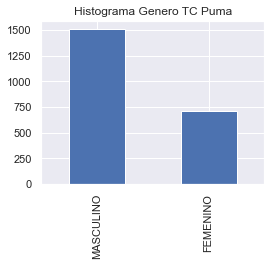

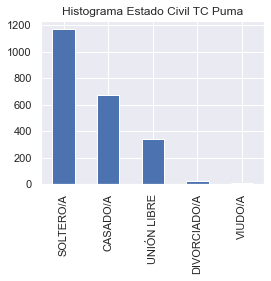

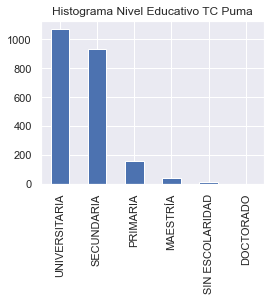

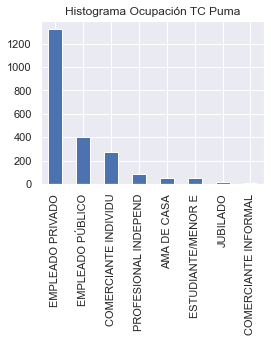

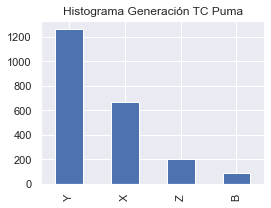

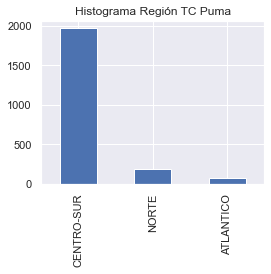

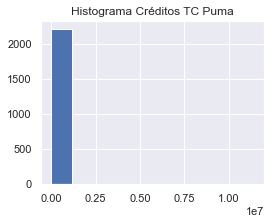

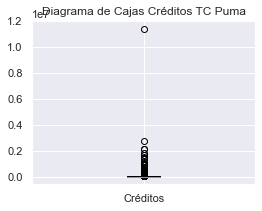

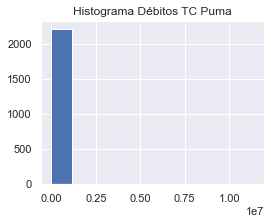

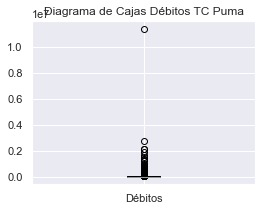

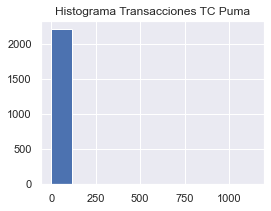

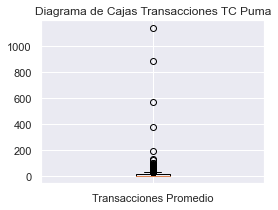

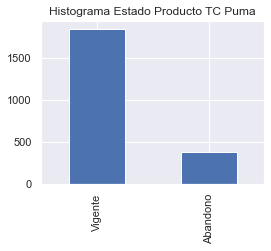

In [64]:
sns.set(style="darkgrid")
pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1)
new_records['GENERO'].value_counts().plot(kind='bar', title='Histograma Genero TC Puma')
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1)
new_records['ESTADO_CIVIL'].value_counts().plot(kind='bar', title='Histograma Estado Civil TC Puma')
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1)
new_records['NIVEL_EDUCATIVO'].value_counts().plot(kind='bar', title='Histograma Nivel Educativo TC Puma')
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1)
new_records['OCUPACION'].value_counts().plot(kind='bar', title='Histograma Ocupación TC Puma')
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1)
new_records['GENERACION'].value_counts().plot(kind='bar', title='Histograma Generación TC Puma')
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1)
new_records['REGION'].value_counts().plot(kind='bar', title='Histograma Región TC Puma')
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1).set_title('Histograma Créditos TC Puma')
pyplot.hist(new_records['CREDITOS'])
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1).set_title('Diagrama de Cajas Créditos TC Puma')
pyplot.boxplot(new_records['CREDITOS'], labels=['Créditos'])
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1).set_title('Histograma Débitos TC Puma')
pyplot.hist(new_records['DEBITOS'])
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1).set_title('Diagrama de Cajas Débitos TC Puma')
pyplot.boxplot(new_records['DEBITOS'], labels=['Débitos'])
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1).set_title('Histograma Transacciones TC Puma')
pyplot.hist(new_records['TRANSACCIONES_PROMEDIO'])
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1).set_title('Diagrama de Cajas Transacciones TC Puma')
pyplot.boxplot(new_records['TRANSACCIONES_PROMEDIO'], labels=['Transacciones Promedio'])
pyplot.show()

pyplot.figure(figsize=(4,3))
pyplot.subplot(1,1,1)
new_records['ESTADO_PRODUCTO'].value_counts().plot(kind='bar', title='Histograma Estado Producto TC Puma')
pyplot.show()

### Creación del Conjunto de Entrenamiento y validación

Primero normalizamos la variable 'NUMERO_DEPENDIENTES'

In [14]:
sc = StandardScaler()

In [15]:
creditos_norm = pd.DataFrame(sc.fit_transform(new_records[['CREDITOS']]),
                             columns = ['CREDITOS'])
debitos_norm = pd.DataFrame(sc.fit_transform(new_records[['DEBITOS']]),
                            columns = ['DEBITOS'])
transacciones_prom_norm = pd.DataFrame(sc.fit_transform(new_records[['TRANSACCIONES_PROMEDIO']]),
                                       columns = ['TRANSACCIONES_PROMEDIO'])

Se crean los dummies para cada variable

In [16]:
genero_dm = pd.get_dummies(new_records.GENERO, prefix='GENERO')
estado_civil_dm = pd.get_dummies(new_records.ESTADO_CIVIL, prefix='EC')
nivel_educativo_dm = pd.get_dummies(new_records.NIVEL_EDUCATIVO, prefix='NIVEL_ED')
ocupacion_dm = pd.get_dummies(new_records.OCUPACION, prefix='OCUPACION')
generacion_dm = pd.get_dummies(new_records.GENERACION, prefix='GENERACION')
region_dm = pd.get_dummies(new_records.REGION, prefix='REGION')

Se crea el nuevo dataset con los dummies y la variable normalizada

In [17]:
dataset_transformado = pd.concat([genero_dm, estado_civil_dm,
                                                 nivel_educativo_dm, ocupacion_dm, generacion_dm,
                                                 region_dm, creditos_norm, debitos_norm,
                                                 transacciones_prom_norm, new_records[['ESTADO_PRODUCTO']]], axis=1)

In [18]:
dataset_transformado.shape

(2223, 32)

In [19]:
lista_datos = dataset_transformado.values
X = lista_datos[:,0:31]
y = lista_datos[:,31]

In [20]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, shuffle=True,test_size=0.20, random_state=10)

Aplicamos la técnica de SMOTE para conseguir el conjunto de datos de entrenamiento

In [21]:
smote = SMOTE()
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

In [22]:
print("Before SMOTE :" , Counter(Y_train))
print("After SMOTE :" , Counter(Y_train_smote))

Before SMOTE : Counter({'Vigente': 1480, 'Abandono': 298})
After SMOTE : Counter({'Vigente': 1480, 'Abandono': 1480})


In [23]:
nombre_clases = ['Abandono', 'Vigente']

## Definimos el diccionario de Variables de análisis

In [24]:
#Se crea un diccionario para cada dataset, el cual contendra un diccionario por cada algoritmo a probar
analisis = {'CART': {}, 'RF': {}, 'KN': {}, 'LReg': {}}

### Entrenamos el modelo CART

In [25]:
analisis['CART']['model'] = DecisionTreeClassifier()
analisis['CART']['model'].fit(X_train_smote, Y_train_smote)
analisis['CART']['model'].classes_

array(['Abandono', 'Vigente'], dtype=object)

Luego lo validamos con el conjunto de datos de validación

In [26]:
analisis['CART']['pred_score'] = analisis['CART']['model'].predict(X_validation)
print(accuracy_score(Y_validation, analisis['CART']['pred_score']))

0.6719101123595506


C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Matriz de Confusión CART Dataset TC Puma Sin Normalizar
[[ 33  45]
 [101 266]]
Matriz de Confusión CART Dataset TC Puma Normalizada
[[0.42307692 0.57692308]
 [0.27520436 0.72479564]]


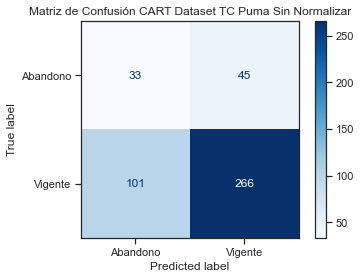

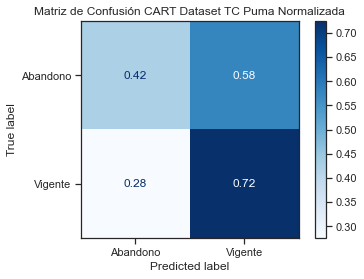

In [27]:
# Plot non-normalized confusion matrix - Tomado de la documentación oficial de scikitlearn
sns.set(style="ticks")
titulos_cm = [("Matriz de Confusión CART Dataset TC Puma Sin Normalizar", None),
                  ("Matriz de Confusión CART Dataset TC Puma Normalizada", 'true')]
for titulo, normalizacion in titulos_cm:
    cart_visualizacion_cm = plot_confusion_matrix(analisis['CART']['model'], X_validation, Y_validation,
                                 display_labels=nombre_clases,
                                 cmap=pyplot.cm.Blues,
                                 normalize=normalizacion)
    cart_visualizacion_cm.ax_.set_title(titulo)

    print(titulo)
    print(cart_visualizacion_cm.confusion_matrix)

pyplot.show()

In [28]:
analisis['CART']['metricas'] = classification_report(Y_validation, analisis['CART']['pred_score'])
print(analisis['CART']['metricas'])

              precision    recall  f1-score   support

    Abandono       0.25      0.42      0.31        78
     Vigente       0.86      0.72      0.78       367

    accuracy                           0.67       445
   macro avg       0.55      0.57      0.55       445
weighted avg       0.75      0.67      0.70       445



También utilizamos la librería pycm para obtener estadísticas más precisas de nuestro modelo predictivo como ser TPR y FPR

In [29]:
analisis['CART']['estadisticas'] = ConfusionMatrix(actual_vector=Y_validation,predict_vector=analisis['CART']['pred_score'])
print(analisis['CART']['estadisticas'])

Predict        Abandono       Vigente        
Actual
Abandono       33             45             

Vigente        101            266            





Overall Statistics : 

95% CI                                                            (0.62829,0.71553)
ACC Macro                                                         0.67191
ARI                                                               0.05406
AUNP                                                              0.57394
AUNU                                                              0.57394
Bangdiwala B                                                      0.57666
Bennett S                                                         0.34382
CBA                                                               0.48553
CSI                                                               0.12472
Chi-Squared                                                       6.68391
Chi-Squared DF                                                    1
Conditio

In [30]:
analisis['CART']['predY'] = analisis['CART']['model'].predict_proba(X_validation)
analisis['CART']['fpr'], analisis['CART']['tpr'], analisis['CART']['thresh'] = roc_curve(Y_validation, 
                                                               analisis['CART']['predY'][:,0], pos_label = 'Abandono')
#print(analisis['CART']['fpr'])
#print(analisis['CART']['tpr'])
#print(analisis['CART']['thresh'])
analisis['CART']['auc'] = auc(analisis['CART']['fpr'], analisis['CART']['tpr'])
print("AUC:", analisis['CART']['auc'])

AUC: 0.5730280164885069


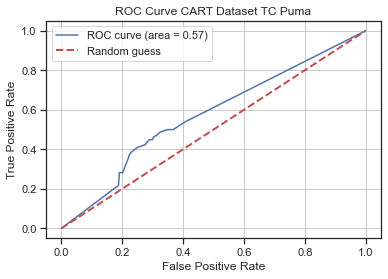

In [31]:
pyplot.plot(analisis['CART']['fpr'], analisis['CART']['tpr'], label='ROC curve (area = %.2f)' %analisis['CART']['auc'])
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.title('ROC Curve CART Dataset TC Puma')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.grid()
pyplot.legend()
pyplot.show()

### Entrenamos el modelo Random Forest

In [32]:
analisis['RF']['model'] = RandomForestClassifier()
analisis['RF']['model'].fit(X_train_smote, Y_train_smote)
analisis['RF']['model'].classes_

array(['Abandono', 'Vigente'], dtype=object)

In [33]:
analisis['RF']['pred_score'] = analisis['RF']['model'].predict(X_validation)
print(accuracy_score(Y_validation, analisis['RF']['pred_score']))

0.7348314606741573


C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Matriz de Confusión RF Dataset TC Puma Sin Normalizar
[[ 33  45]
 [ 73 294]]
Matriz de Confusión RF Dataset TC Puma Normalizada
[[0.42307692 0.57692308]
 [0.19891008 0.80108992]]


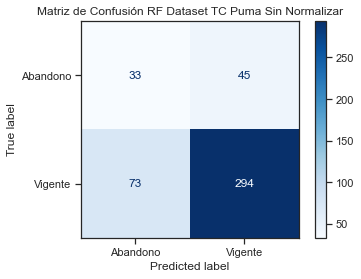

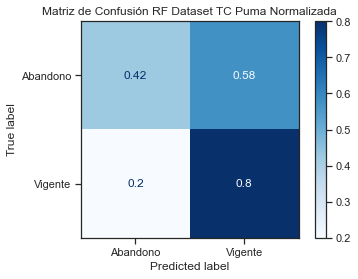

In [34]:
# Plot non-normalized confusion matrix - Tomado de la documentación oficial de scikitlearn
sns.set(style="ticks")
titulos_cm = [("Matriz de Confusión RF Dataset TC Puma Sin Normalizar", None),
                  ("Matriz de Confusión RF Dataset TC Puma Normalizada", 'true')]
for titulo, normalizacion in titulos_cm:
    rf_visualizacion_cm = plot_confusion_matrix(analisis['RF']['model'], X_validation, Y_validation,
                                 display_labels=nombre_clases,
                                 cmap=pyplot.cm.Blues,
                                 normalize=normalizacion)
    rf_visualizacion_cm.ax_.set_title(titulo)

    print(titulo)
    print(rf_visualizacion_cm.confusion_matrix)

pyplot.show()

In [35]:
analisis['RF']['metricas'] = classification_report(Y_validation, analisis['RF']['pred_score'])
print(analisis['RF']['metricas'])

              precision    recall  f1-score   support

    Abandono       0.31      0.42      0.36        78
     Vigente       0.87      0.80      0.83       367

    accuracy                           0.73       445
   macro avg       0.59      0.61      0.60       445
weighted avg       0.77      0.73      0.75       445



In [36]:
analisis['RF']['estadisticas'] = ConfusionMatrix(actual_vector=Y_validation,predict_vector=analisis['RF']['pred_score'])
print(analisis['RF']['estadisticas'])

Predict        Abandono       Vigente        
Actual
Abandono       33             45             

Vigente        73             294            





Overall Statistics : 

95% CI                                                            (0.69382,0.77585)
ACC Macro                                                         0.73483
ARI                                                               0.11773
AUNP                                                              0.61208
AUNU                                                              0.61208
Bangdiwala B                                                      0.65966
Bennett S                                                         0.46966
CBA                                                               0.55621
CSI                                                               0.20137
Chi-Squared                                                       17.81385
Chi-Squared DF                                                    1
Conditi

In [37]:
analisis['RF']['predY'] = analisis['RF']['model'].predict_proba(X_validation)
analisis['RF']['fpr'], analisis['RF']['tpr'], analisis['RF']['thresh'] = roc_curve(Y_validation, 
                                                               analisis['RF']['predY'][:,0], pos_label = 'Abandono')
#print(analisis['CART']['fpr'])
#print(analisis['CART']['tpr'])
#print(analisis['CART']['thresh'])
analisis['RF']['auc'] = auc(analisis['RF']['fpr'], analisis['RF']['tpr'])
print("AUC:", analisis['RF']['auc'])

AUC: 0.6086424928386781


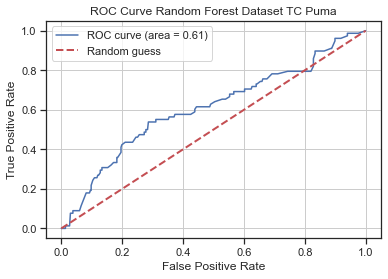

In [38]:
pyplot.plot(analisis['RF']['fpr'], analisis['RF']['tpr'], label='ROC curve (area = %.2f)' %analisis['RF']['auc'])
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.title('ROC Curve Random Forest Dataset TC Puma')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.grid()
pyplot.legend()
pyplot.show()

### Entrenamos el modelo KNeighbors

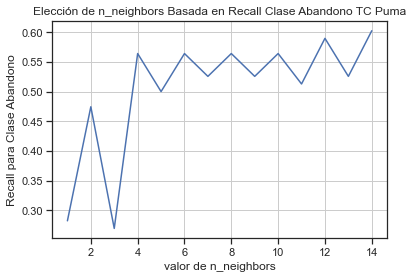

In [39]:
range_k = range(1,15)
kn_scores = []
kn_scores_list = []
for k in range_k:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train_smote, Y_train_smote)
    kn_y_pred = classifier.predict(X_validation)
    kn_scores.append(accuracy_score(Y_validation,kn_y_pred))
    kn_scores_list.append(recall_score(Y_validation, kn_y_pred, pos_label = 'Abandono'))

pyplot.plot(range_k,kn_scores_list)
pyplot.title('Elección de n_neighbors Basada en Recall Clase Abandono TC Puma')
pyplot.xlabel("valor de n_neighbors")
pyplot.ylabel("Recall para Clase Abandono")
pyplot.grid()
pyplot.show()

In [41]:
analisis['KN']['model'] = KNeighborsClassifier(n_neighbors=4)
analisis['KN']['model'].fit(X_train_smote, Y_train_smote)
analisis['KN']['model'].classes_

array(['Abandono', 'Vigente'], dtype=object)

In [42]:
analisis['KN']['pred_score'] = analisis['KN']['model'].predict(X_validation)
print(accuracy_score(Y_validation, analisis['KN']['pred_score']))

0.5573033707865168


C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Matriz de Confusión KNeighbors Dataset TC Puma Sin Normalizar
[[ 44  34]
 [163 204]]
Matriz de Confusión KNeighbors Dataset TC Puma Normalizada
[[0.56410256 0.43589744]
 [0.44414169 0.55585831]]


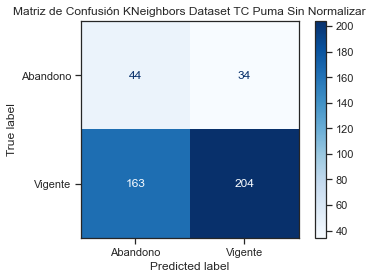

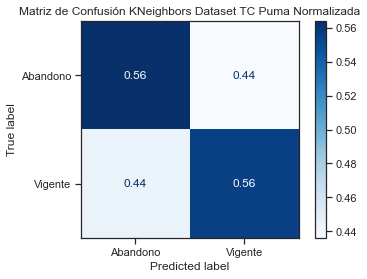

In [43]:
# Plot non-normalized confusion matrix - Tomado de la documentación oficial de scikitlearn
sns.set(style="ticks")
titulos_cm = [("Matriz de Confusión KNeighbors Dataset TC Puma Sin Normalizar", None),
                  ("Matriz de Confusión KNeighbors Dataset TC Puma Normalizada", 'true')]
for titulo, normalizacion in titulos_cm:
    kn_visualizacion_cm = plot_confusion_matrix(analisis['KN']['model'], X_validation, Y_validation,
                                 display_labels=nombre_clases,
                                 cmap=pyplot.cm.Blues,
                                 normalize=normalizacion)
    kn_visualizacion_cm.ax_.set_title(titulo)

    print(titulo)
    print(kn_visualizacion_cm.confusion_matrix)

pyplot.show()

In [44]:
analisis['KN']['metricas'] = classification_report(Y_validation, analisis['KN']['pred_score'])
print(analisis['KN']['metricas'])

              precision    recall  f1-score   support

    Abandono       0.21      0.56      0.31        78
     Vigente       0.86      0.56      0.67       367

    accuracy                           0.56       445
   macro avg       0.53      0.56      0.49       445
weighted avg       0.74      0.56      0.61       445



In [45]:
analisis['KN']['estadisticas'] = ConfusionMatrix(actual_vector=Y_validation,predict_vector=analisis['KN']['pred_score'])
print(analisis['KN']['estadisticas'])

Predict        Abandono       Vigente        
Actual
Abandono       44             34             

Vigente        163            204            





Overall Statistics : 

95% CI                                                            (0.51115,0.60345)
ACC Macro                                                         0.5573
ARI                                                               0.00982
AUNP                                                              0.55998
AUNU                                                              0.55998
Bangdiwala B                                                      0.42082
Bennett S                                                         0.11461
CBA                                                               0.38421
CSI                                                               0.09483
Chi-Squared                                                       3.72094
Chi-Squared DF                                                    1
Condition

In [46]:
analisis['KN']['predY'] = analisis['KN']['model'].predict_proba(X_validation)
analisis['KN']['fpr'], analisis['KN']['tpr'], analisis['KN']['thresh'] = roc_curve(Y_validation, 
                                                               analisis['KN']['predY'][:,0], pos_label = 'Abandono')
#print(analisis['KN']['fpr'])
#print(analisis['KN']['tpr'])
#print(analisis['KN']['thresh'])
analisis['KN']['auc'] = auc(analisis['KN']['fpr'], analisis['KN']['tpr'])
print("AUC:", analisis['KN']['auc'])

AUC: 0.5995249074268147


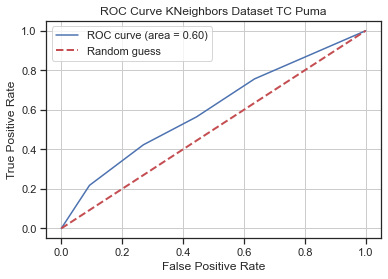

In [47]:
pyplot.plot(analisis['KN']['fpr'], analisis['KN']['tpr'], label='ROC curve (area = %.2f)' %analisis['KN']['auc'])
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.title('ROC Curve KNeighbors Dataset TC Puma')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.grid()
pyplot.legend()
pyplot.show()

### Entrenamos el modelo Logistic Regression

C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


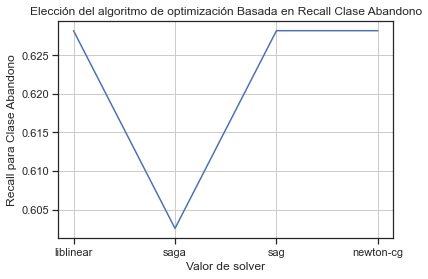

In [48]:
solver = ['liblinear', 'saga', 'sag', 'newton-cg']
lr_scores = {}
lr_scores_list = []
for k in solver:
    classifier = LogisticRegression(random_state=0, solver=k)
    classifier.fit(X_train_smote, Y_train_smote)
    lr_y_pred = classifier.predict(X_validation)
    lr_scores[k] = accuracy_score(Y_validation,lr_y_pred)
    lr_scores_list.append(recall_score(Y_validation, lr_y_pred, pos_label = 'Abandono'))

pyplot.plot(solver,lr_scores_list)
pyplot.title('Elección del algoritmo de optimización Basada en Recall Clase Abandono')
pyplot.xlabel("Valor de solver")
pyplot.ylabel("Recall para Clase Abandono")
pyplot.grid()
pyplot.show()

In [56]:
analisis['LReg']['model'] = LogisticRegression(random_state=0, solver='liblinear')
analisis['LReg']['model'].fit(X_train_smote, Y_train_smote)
analisis['LReg']['model'].classes_

array(['Abandono', 'Vigente'], dtype=object)

In [57]:
analisis['LReg']['pred_score'] = analisis['LReg']['model'].predict(X_validation)
print(accuracy_score(Y_validation, analisis['LReg']['pred_score']))

0.5078651685393258


C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\scmartinez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Matriz de Confusión LReg Dataset TC Puma Sin Normalizar
[[ 49  29]
 [190 177]]
Matriz de Confusión LReg Dataset TC Puma Normalizada
[[0.62820513 0.37179487]
 [0.51771117 0.48228883]]


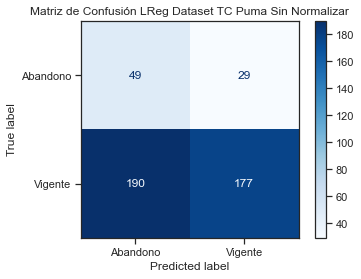

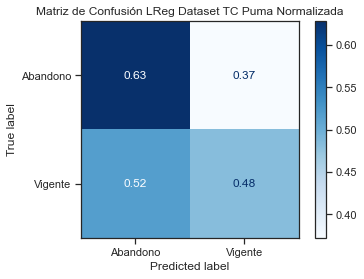

In [58]:
# Plot non-normalized confusion matrix - Tomado de la documentación oficial de scikitlearn
sns.set(style="ticks")
titulos_cm = [("Matriz de Confusión LReg Dataset TC Puma Sin Normalizar", None),
                  ("Matriz de Confusión LReg Dataset TC Puma Normalizada", 'true')]
for titulo, normalizacion in titulos_cm:
    lr_visualizacion_cm = plot_confusion_matrix(analisis['LReg']['model'], X_validation, Y_validation,
                                 display_labels=nombre_clases,
                                 cmap=pyplot.cm.Blues,
                                 normalize=normalizacion)
    lr_visualizacion_cm.ax_.set_title(titulo)

    print(titulo)
    print(lr_visualizacion_cm.confusion_matrix)

pyplot.show()

In [59]:
analisis['LReg']['metricas'] = classification_report(Y_validation, analisis['LReg']['pred_score'])
print(analisis['LReg']['metricas'])

              precision    recall  f1-score   support

    Abandono       0.21      0.63      0.31        78
     Vigente       0.86      0.48      0.62       367

    accuracy                           0.51       445
   macro avg       0.53      0.56      0.46       445
weighted avg       0.74      0.51      0.56       445



In [60]:
analisis['LReg']['estadisticas'] = ConfusionMatrix(actual_vector=Y_validation,predict_vector=analisis['LReg']['pred_score'])
print(analisis['LReg']['estadisticas'])

Predict        Abandono       Vigente        
Actual
Abandono       49             29             

Vigente        190            177            





Overall Statistics : 

95% CI                                                            (0.46141,0.55432)
ACC Macro                                                         0.50787
ARI                                                               -0.00338
AUNP                                                              0.55525
AUNU                                                              0.55525
Bangdiwala B                                                      0.3579
Bennett S                                                         0.01573
CBA                                                               0.34365
CSI                                                               0.08737
Chi-Squared                                                       3.15888
Chi-Squared DF                                                    1
Conditio

In [61]:
analisis['LReg']['predY'] = analisis['LReg']['model'].predict_proba(X_validation)
analisis['LReg']['fpr'], analisis['LReg']['tpr'], analisis['LReg']['thresh'] = roc_curve(Y_validation, 
                                                               analisis['LReg']['predY'][:,0], pos_label = 'Abandono')
#print(analisis['LReg']['fpr'])
#print(analisis['LReg']['tpr'])
#print(analisis['LReg']['thresh'])
analisis['LReg']['auc'] = auc(analisis['LReg']['fpr'], analisis['LReg']['tpr'])
print("AUC:", analisis['LReg']['auc'])

AUC: 0.598407042548732


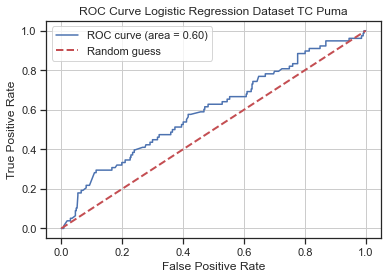

In [62]:
pyplot.plot(analisis['LReg']['fpr'], analisis['LReg']['tpr'], label='ROC curve (area = %.2f)' %analisis['LReg']['auc'])
pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
pyplot.title('ROC Curve Logistic Regression Dataset TC Puma')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.grid()
pyplot.legend()
pyplot.show()